# Frozen Lake experiments

In [16]:
import copy
import gym
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

# generate the map
env_frozenlake = gym.make('FrozenLake-v0', map_name='8x8')
env_frozenlake.reset()
env_frozenlake.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [2]:
# don't stop the env on holes and add penalty
def continue_on_hole(env, penalty = 0.01, goal_reward = 1):
    env.penalty = penalty
    env_modified = copy.deepcopy(env)
    desc = env.desc.flatten()
    for s in range(env.nS):
        for a in range(env.nA):
            possible_outcomes = env.P[s][a]
            new_possible_outcomes = []
            for outcome in possible_outcomes:
                prob, next_state, reward, done = outcome
                if desc[next_state] == b'G':
                    reward = goal_reward
                if desc[next_state] == b'H':
                    done = False
                    reward = -penalty
                new_possible_outcomes.append((prob, next_state, reward, done))
            env_modified.P[s][a] = new_possible_outcomes
    return env_modified

In [3]:
# The policy given a Qfunc
class policy_from_Qfunc(object):
    def __init__(self, Qfunc, random_tie_breaking = False):
        self.Qfunc = Qfunc
        self.random_tie_breaking = random_tie_breaking
        
    def act_from_values(self, values):
        if self.random_tie_breaking:
            inds = np.flatnonzero(values == values.max())
            a = np.random.choice(inds)
        else:
            a = np.argmax(values)
        return a
    
    def act(self, s):
        values = self.Qfunc[s, :]
        return self.act_from_values(values)

In [4]:
# Frozen Lake experiments for a policy
def run_exp(env, policy, n_exp = 1000, max_iter = None, seed = None, render = False, print_result = False):
    if seed is not None:
        env.seed(seed)
        
    if max_iter is None:
        # use the default max_episode_steps
        max_iter = env._max_episode_steps
        
    desc = env.desc.flatten()
    
    reward_total = 0.0
    danger_total = 0.0
    for exp in range(n_exp):
        s = env.reset()
        for i in range(max_iter):
            a = policy.act(s)
            s, r, done, info = env.step(a)
            if desc[s] == b'H':
                danger_total += env.penalty
            if desc[s] == b'G':
                reward_total += 1
            if render:
                env.render()
            if done:
                break
    if print_result:
        print('Avg collision rate: {:.3f}'.format(danger_total / n_exp), 
              'Avg reward: {:.3f}'.format(reward_total / n_exp)
             )
    return danger_total / n_exp, reward_total / n_exp

# Value iteration and optimal policy with Lagrange multiplier

In [5]:
class ValueIterationAgent(object):
    def __init__(self, env, Qfunc_init = None, gamma = 0.99, max_iter = None):
        self.env = env
        self.gamma = gamma
        if max_iter is None:
            self.max_iter = env._max_episode_steps
        else:
            self.max_iter = max_iter
        if Qfunc_init is None:
            self.Qfunc = np.zeros([self.env.nS, self.env.nA])
        else:
            self.Qfunc = Qfunc_init
        self.Vfunc = np.zeros(self.env.nS)
    
    def compute_V_from_Q(self):
        self.Vfunc = np.max(self.Qfunc, axis=1)
    def compute_Q_from_next_V(self):
        for s in range(self.env.nS):
            for a in range(self.env.nA):
                self.Qfunc[s, a] = 0
                possible_outcomes = self.env.P[s][a]
                for outcome in possible_outcomes:
                    prob, next_state, reward, done = outcome
                    future_reward = 0 if done else self.Vfunc[next_state]
                    self.Qfunc[s, a] += prob * (reward + self.gamma * future_reward)
            
    def do_value_iteration(self):
        self.compute_V_from_Q()
        for i in range(self.max_iter):    
            old_V = self.Vfunc.copy()
            self.compute_Q_from_next_V()
            self.compute_V_from_Q()
            if np.allclose(self.Vfunc, old_V):
                break
        
    def get_policy(self):
        return policy_from_Qfunc(self.Qfunc)

In [6]:
# The Lagrange multiplier method
penalty_list = [0, 0.01, 0.02, 0.09, 0.1]
env_list = []
for penalty in penalty_list:
    env_list.append(continue_on_hole(env_frozenlake, penalty=penalty))

env_test = continue_on_hole(env_frozenlake, penalty=1)

def LM_exp_curve(env_list, print_result=False):
    reward_list = []
    danger_list = []
    for i, env in enumerate(env_list):
        VI_FL = ValueIterationAgent(env)
        VI_FL.do_value_iteration()
        policy = VI_FL.get_policy()
        danger, reward = run_exp(env_test, policy)
        if print_result:
            print('the {}th env avg danger {:.3f} and avg reward {:.3f}'.format(i, danger, reward))
        reward_list.append(reward)
        danger_list.append(danger)
    return danger_list, reward_list

danger_LM, reward_LM = LM_exp_curve(env_list)

# RMDP

In [7]:
# Construct the RMDP by chaning the reward
# Reward is -1 if on a hole `H` or 0 otherwise
env_RMDP = continue_on_hole(env_frozenlake, penalty=1, goal_reward=0)

In [8]:
# Construct the RMDP by chaning the reward
# Reward is -1 if on a hole `H` or 0 otherwise
env_RMDP = continue_on_hole(env_frozenlake, penalty=1, goal_reward=0)

# Solve the RMDP and test its optimal policy in the original Frozen Lake
VI_RMDP = ValueIterationAgent(env_RMDP)
VI_RMDP.do_value_iteration()
print('RMDP policy in Frozen Lake:')
run_exp(env_frozenlake, VI_RMDP.get_policy(), print_result=True);

RMDP policy in Frozen Lake:
Avg collision rate: 0.000 Avg reward: 0.000


# Visualization of the threat function

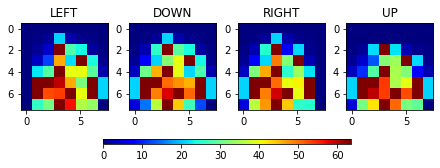

In [9]:
env = env_frozenlake
TF = -VI_RMDP.Qfunc
TF_grid = np.zeros((env.nrow, env.ncol, env.nA))
x_arr = np.arange(0, env.nrow, 1)
y_arr = np.arange(0, env.ncol, 1)
for row in x_arr:
    for col in y_arr:
        for a in range(env.nA):
            s = row*env.ncol + col
            TF_grid[row, col, a] = TF[s][a]

fig, ax = plt.subplots(1, 4, constrained_layout=True)
a_list = ['LEFT', 'DOWN', 'RIGHT', 'UP']
for a in range(env.nA):
    ax[a].set_title(a_list[a])
    pcm = ax[a].imshow(TF_grid[:,:,a], cmap=cm.jet)

fig.colorbar(pcm, ax=ax[:], shrink=0.6, location='bottom')

# Solve PMDP using the RMDP Q-function

In [10]:
# RP policy given a threat function
class policy_RP(policy_from_Qfunc):
    def __init__(self, Qfunc, threat_function, threat_threshold = 0.03, random_tie_breaking = False):
        super().__init__(Qfunc, random_tie_breaking)
        self.threat_function = threat_function
        self.threat_threshold = threat_threshold
        self.is_safe_action_list = []
        for s in range(self.threat_function.shape[0]):
            self.is_safe_action_list.append(self.threat_function[s, :] < self.threat_threshold)
    def act(self, s):
        is_safe_action = self.is_safe_action_list[s]
        if np.any(is_safe_action):
            # replace the values of non-safe actions to -inf
            values = np.where(is_safe_action, self.Qfunc[s, :], - np.inf)
        else:
            # no safe actions, follow RMDP policy from negative threat function
            values = - self.threat_function[s, :]
        
        return self.act_from_values(values)

    
class RPValueIterationAgent(ValueIterationAgent):
    def __init__(self, env, threat_function, **kwargs):
        self.threat_function = threat_function
        self.threat_threshold = kwargs.pop('threat_threshold')
        self.is_safe_action_list = []
        for s in range(env.nS):
            self.is_safe_action_list.append(self.threat_function[s, :] < self.threat_threshold)
         
        super().__init__(env, **kwargs)
    
    def compute_V_from_Q(self):
        for s in range(self.env.nS):
            is_safe_action = self.is_safe_action_list[s]
            
            if np.any(is_safe_action):
                self.Vfunc[s] = np.max(self.Qfunc[s, is_safe_action])
            else:
                action_from_threat_func = np.argmin(self.threat_function[s, :])
                self.Vfunc[s] = self.Qfunc[s, action_from_threat_func]

    def get_policy(self):
        return policy_RP(self.Qfunc, self.threat_function, self.threat_threshold)

In [11]:
env_train = continue_on_hole(env_frozenlake, penalty = 0)
env_test = continue_on_hole(env_frozenlake, penalty = 1)

def RP_exp_curve(threat_threshold_list, threat_function, n_exp=3000, print_result=False):
    reward_list = []
    danger_list = []
    for i, threat_threshold in enumerate(threat_threshold_list):
        RP_VI = RPValueIterationAgent(env_train, threat_function, threat_threshold=threat_threshold)
        RP_VI.do_value_iteration()
        policy = RP_VI.get_policy()
        danger, reward = run_exp(env_test, policy, n_exp=n_exp)
        if print_result:
            print('the {}/{}th case avg danger {:.3f} and avg reward {:.3f}'.format(i, len(threat_threshold_list), danger, reward))
        reward_list.append(reward)
        danger_list.append(danger)
    return danger_list, reward_list

In [12]:
# PMDP policy in Frozen Lake
n_exp = 3000
threat_threshold_list_logx = np.logspace(-4.0, 1.0, num=20)

danger_rp, reward_rp = RP_exp_curve(threat_threshold_list_logx, -VI_RMDP.Qfunc, n_exp=n_exp)

In [13]:
# compute the threat function for a heuristic policy
def policy_evaluation(env, policy, gamma=0.99):
    Qfunc = np.zeros([env.nS, env.nA])
    for i in range(env._max_episode_steps): 
        Qfunc_new = np.zeros([env.nS, env.nA])
        for s in range(env.nS):
            for a in range(env.nA):
                possible_outcomes = env.P[s][a]
                for outcome in possible_outcomes:
                    prob, next_state, reward, done = outcome
                    future_reward = 0 if done else Qfunc[next_state, policy.act(next_state)]
                    Qfunc_new[s, a] += prob * (reward + gamma * future_reward)
        Qfunc = Qfunc_new
    return Qfunc


def random_policy_evaluation(env, gamma=0.99):
    Qfunc = np.zeros([env.nS, env.nA])
    for i in range(env._max_episode_steps): 
        Qfunc_new = np.zeros([env.nS, env.nA])
        for s in range(env.nS):
            for a in range(env.nA):
                possible_outcomes = env.P[s][a]
                for outcome in possible_outcomes:
                    prob, next_state, reward, done = outcome
                    future_reward = 0
                    if not done:
                        for next_a in range(env.nA):
                            future_reward += Qfunc[next_state, next_a] / env.nA
                    
                    Qfunc_new[s, a] += prob * (reward + gamma * future_reward)
        Qfunc = Qfunc_new
    return Qfunc


Qfunc_heuristic1 = random_policy_evaluation(env_RMDP)
policy_heuristic1 = policy_from_Qfunc(Qfunc_heuristic1)
Qfunc_heuristic2 = policy_evaluation(env_RMDP, policy_heuristic1)
policy_heuristic2 = policy_from_Qfunc(Qfunc_heuristic2)
Qfunc_heuristic3 = policy_evaluation(env_RMDP, policy_heuristic2)

In [14]:
# run experiments
danger_rp1, reward_rp1 = RP_exp_curve(threat_threshold_list_logx, -Qfunc_heuristic1, n_exp=n_exp)
danger_rp2, reward_rp2 = RP_exp_curve(threat_threshold_list_logx, -Qfunc_heuristic2, n_exp=n_exp)
danger_rp3, reward_rp3 = RP_exp_curve(threat_threshold_list_logx, -Qfunc_heuristic3, n_exp=n_exp)

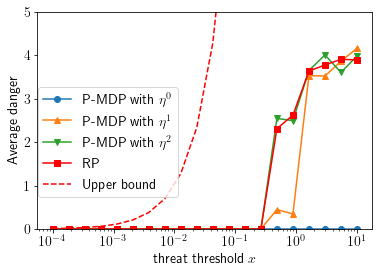

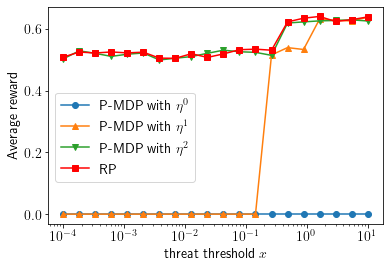

In [17]:
plt.rcParams.update({'font.size': 14})
rc('text', usetex=True)
plt.figure()

plt.plot(threat_threshold_list_logx, danger_rp1, 'o-', label=r'P-MDP with $\eta^0$')
plt.plot(threat_threshold_list_logx, danger_rp2, '^-', label=r'P-MDP with $\eta^1$')
plt.plot(threat_threshold_list_logx, danger_rp3, 'v-', label=r'P-MDP with $\eta^2$')
plt.plot(threat_threshold_list_logx, danger_rp, 'rs-', label='RP')

plt.plot(threat_threshold_list_logx, threat_threshold_list_logx * 100, 'r--', 
             label='Upper bound') 
plt.ylim(0, 5)
plt.xscale('log')
plt.xlabel(r'threat threshold $x$')
plt.ylabel('Average danger')
plt.legend(loc = 'center left', bbox_to_anchor=(-0.02, 0.4))

plt.figure()

plt.plot(threat_threshold_list_logx, reward_rp1, 'o-', label=r'P-MDP with $\eta^0$')
plt.plot(threat_threshold_list_logx, reward_rp2, '^-', label=r'P-MDP with $\eta^1$')
plt.plot(threat_threshold_list_logx, reward_rp3, 'v-', label=r'P-MDP with $\eta^2$')
plt.plot(threat_threshold_list_logx, reward_rp, 'rs-', label='RP')
plt.xscale('log')
plt.xlabel(r'threat threshold $x$')
plt.ylabel('Average reward')
plt.legend(loc = 'center left', bbox_to_anchor=(0, 0.4))

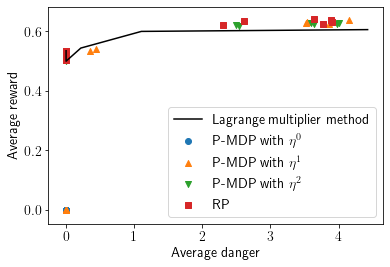

In [18]:
plt.figure()
plt.scatter(danger_rp1, reward_rp1, marker='o', label=r'P-MDP with $\eta^0$')
plt.scatter(danger_rp2, reward_rp2, marker='^', label=r'P-MDP with $\eta^1$')
plt.scatter(danger_rp3, reward_rp3, marker='v', label=r'P-MDP with $\eta^2$')
plt.scatter(danger_rp, reward_rp, marker='s', label='RP')

plt.plot(danger_LM, reward_LM, 'k-', label='Lagrange multiplier method' )
plt.xlabel('Average danger')
plt.ylabel('Average reward')
plt.legend()